<a href="https://colab.research.google.com/github/noambassat/RAG_project/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install langchain faiss-cpu transformers

In [2]:
!pip install adjustText

In [3]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.embeddings.base import Embeddings
from transformers import AutoTokenizer, AutoModel
from langchain.vectorstores import FAISS
import faiss
import torch
import numpy as np
from tqdm import tqdm
import pandas as pd
import re
from concurrent.futures import ThreadPoolExecutor, as_completed
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive
from sentence_transformers import SentenceTransformer
import json
import random
import umap
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text
import time

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
clean_df = pd.read_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx")

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_colwidth', None)

### Preparing the **CustomCodeBERTEmbeddings** Model  
The **CodeBERT** model is designed for code-related data. It is based on **BERT** and trained with code data. This model allows generating representations of texts using a **tokenizer** and a **model**.  

### The **embed_documents** Function  
This function generates embeddings for each given text by:  
- **Tokenization:** Breaking down the text into tokens.  
- **Text Splitting:** Dividing texts based on length to fit the model’s input limit.  
- **Batch Processing:** Producing embeddings in batches to improve efficiency.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class CustomCodeBERTEmbeddings(Embeddings):
    def __init__(self, model_name="microsoft/codebert-base"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    def embed_documents(self, texts, batch_size=64):  # הוספנו batch_size כארגומנט
        embeddings = []

        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            inputs = self.tokenizer(batch, padding=True, truncation=True, return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = self.model(**inputs)

            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()  # שימוש ב-CLS Token
            embeddings.extend(batch_embeddings)

        return np.array(embeddings)

    def embed_query(self, query):
        return self.embed_documents([query])[0]

# יצירת אובייקט מותאם אישית
embeddings = CustomCodeBERTEmbeddings()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Data Preparation  
At this stage, the program prepares **all_tokens** and **index_mapping**, allowing me to track which tokens belong to each position in the data.  

Then, the **embed_documents** function is used to generate embeddings for the tokens. Each embedding is stored as a vector, and the information is saved in a dictionary called **vector_to_repo** to link each embedding to its original location in the data.

In [8]:
all_vectors, vector_to_repo = [], {}
current_index = 0
batch_size = 64

# הכנת רשימות שמכילות את כל ה-Tokens מתוך ה-DataFrame
all_tokens, index_mapping = [], []
for index, topic in tqdm(enumerate(clean_df["Topics"]), total=len(clean_df), desc="Extracting Tokens"):
    if not(isinstance(topic, str) and len(topic.strip()) > 0): continue
    tokens = [token.strip() for token in topic.split(",") if token.strip()]
    all_tokens.extend(tokens)
    index_mapping.extend([index] * len(tokens))

# יצירת האימבדינגס בצורה יעילה עם Batching
all_vectors = embeddings.embed_documents(all_tokens, batch_size=batch_size)

# שמירת המידע במילון כדי שנוכל לחזור למיקום המקורי בדאטה
for i, vector in enumerate(all_vectors):
    vector_to_repo[i] = index_mapping[i]

# המרת הוקטורים למערך NumPy
all_vectors = np.array(all_vectors, dtype='float32')


Extracting Tokens: 100%|██████████| 15818/15818 [00:00<00:00, 366159.29it/s]


### Creating Indexes with FAISS  
**FAISS** is a tool optimized for vector-based searches. At this stage, the system creates an **Index** for each different **nlist** group.  

Different indexes are built to allow efficient storage and searching over all the generated embeddings.  

A new index is constructed for each **nlist**, which is periodically evaluated through searches to select the optimal values.

In [9]:
def create_optimized_faiss_indexes(all_vectors, nlist_values):
    """
    Creating Different Indexes with FAISS for Various nlist Values
    """
    d = all_vectors.shape[1]
    indexes = {}

    for nlist in nlist_values:
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)

        index.train(all_vectors)
        index.add(all_vectors)

        indexes[nlist] = index
        # print(f"\n Created FAISS index with nlist={nlist}. Number of embeddings indexed: {index.ntotal}")

    return indexes


nlist_values = [100, 200, 300, 500]
indexes = create_optimized_faiss_indexes(all_vectors, nlist_values)


### Searching with FAISS  
At this stage, the search is performed within the created indexes. A user query is provided (e.g., "deep learning"), and the model searches for the most similar results by comparing embeddings.  

The **search_in_index** function searches for the closest words to the query and returns the results along with the words, topics, and relevant links.

In [10]:
def search_in_index(query: str, index, top_k: int = 10, nprobe: int = 10):
    """
    Advanced Search with FAISS using IndexIVFFlat
    """
    index.nprobe = nprobe
    query_vector = embeddings.embed_query(query)

    start_time = time.time()  # מדידת זמן ריצה
    distances, indices = index.search(np.array([query_vector], dtype='float32'), top_k)
    end_time = time.time()

    results = []
    for i, idx in enumerate(indices[0]):
        if idx == -1:
            continue

        repo_index = vector_to_repo[idx]
        repo_name = clean_df.iloc[repo_index]["Name"]
        repo_url = clean_df.iloc[repo_index]["URL"]
        repo_topics = clean_df.iloc[repo_index]["Topics"]
        score = distances[0][i]

        results.append({
            "name": repo_name,
            "url": repo_url,
            "topics": repo_topics,
            "score": score
        })

    search_time = end_time - start_time
    return results, search_time


### Grid Search  
To maximize system performance, a **Grid Search** is performed where different parameter values, such as **nlist** and **nprobe**, are tested.  

This process allows me to evaluate search time, the number of relevant results, and filter the results optimally.

In [11]:
def grid_search_faiss(queries, indexes, nprobe_values, top_k=10):
    """
    Performing Searches for All Combinations of nlist and nprobe
    """
    results_summary = []

    for nlist, index in indexes.items():
        for nprobe in nprobe_values:
            for query in queries:
                search_results, search_time = search_in_index(query, index, top_k=top_k, nprobe=nprobe)


                found_projects = [result['name'] for result in search_results]
                found_topics = [result['topics'] for result in search_results]
                found_urls = [result['url'] for result in search_results]
                found_scores = [result['score'] for result in search_results]


                results_summary.append({
                    "query": query,
                    "nlist": nlist,
                    "nprobe": nprobe,
                    "top_k": top_k,
                    "search_time": search_time,
                    "relevant_results": len(found_projects),
                    "found_projects": found_projects,
                    "found_topics": found_topics,
                    "found_urls": found_urls,
                    "found_scores": found_scores

                })


    results_df = pd.DataFrame(results_summary)
    return results_df


In [12]:
queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]
nprobe_values = [10, 20, 30, 50]

results_df = grid_search_faiss(queries, indexes, nprobe_values, top_k=10)

In [13]:
results_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79
query,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing,deep learning,neural networks,python libraries,computer vision,natural language processing
nlist,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,200,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,300,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500,500
nprobe,10,10,10,10,10,20,20,20,20,20,30,30,30,30,30,50,50,50,50,50,10,10,10,10,10,20,20,20,20,20,30,30,30,30,30,50,50,50,50,50,10,10,10,10,10,20,20,20,20,20,30,30,30,30,30,50,50,50,50,50,10,10,10,10,10,20,20,20,20,20,30,30,30,30,30,50,50,50,50,50
top_k,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
search_time,0.005808,0.005162,0.005268,0.005882,0.00447,0.009283,0.009081,0.010332,0.009086,0.008754,0.011729,0.012869,0.013272,0.014269,0.011827,0.018453,0.018172,0.019521,0.019611,0.017926,0.003425,0.00262,0.003282,0.003079,0.002071,0.005775,0.005647,0.005307,0.005425,0.004578,0.007832,0.00803,0.009271,0.008694,0.00754,0.012357,0.012637,0.013584,0.013264,0.011726,0.002815,0.001962,0.002219,0.00216,0.001544,0.003979,0.00347,0.003856,0.004065,0.003062,0.005233,0.004974,0.005468,0.005621,0.004355,0.008194,0.007997,0.009457,0.009271,0.007865,0.001847,0.001318,0.001652,0.001545,0.001181,0.002913,0.002468,0.002476,0.002604,0.002042,0.003865,0.003417,0.003226,0.00357,0.002609,0.005404,0.005277,0.005491,0.005846,0.004191
relevant_results,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
found_projects,"[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[student-management-using-django, json-sempai,...","[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[nsot, pandora, robin, LiLT, PICK-pytorch, tra...","[DocTr, hlb-CIFAR10, beartype, alfred-stackexc...","[DocTr, beartype, alfred-stackexchange, nsot, ...","[student-management-using-django, json-sempai,...","[json-sempai, python-vpn, unsupervised-depth-c...","[DeepAFx-ST, nsot, pwncat, penelope, madbg, dj...","[DocTr, how-to-exploit

In [14]:
# query = "best practices for deep learning models"
# answer = generate_answer(query)
# print(answer)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


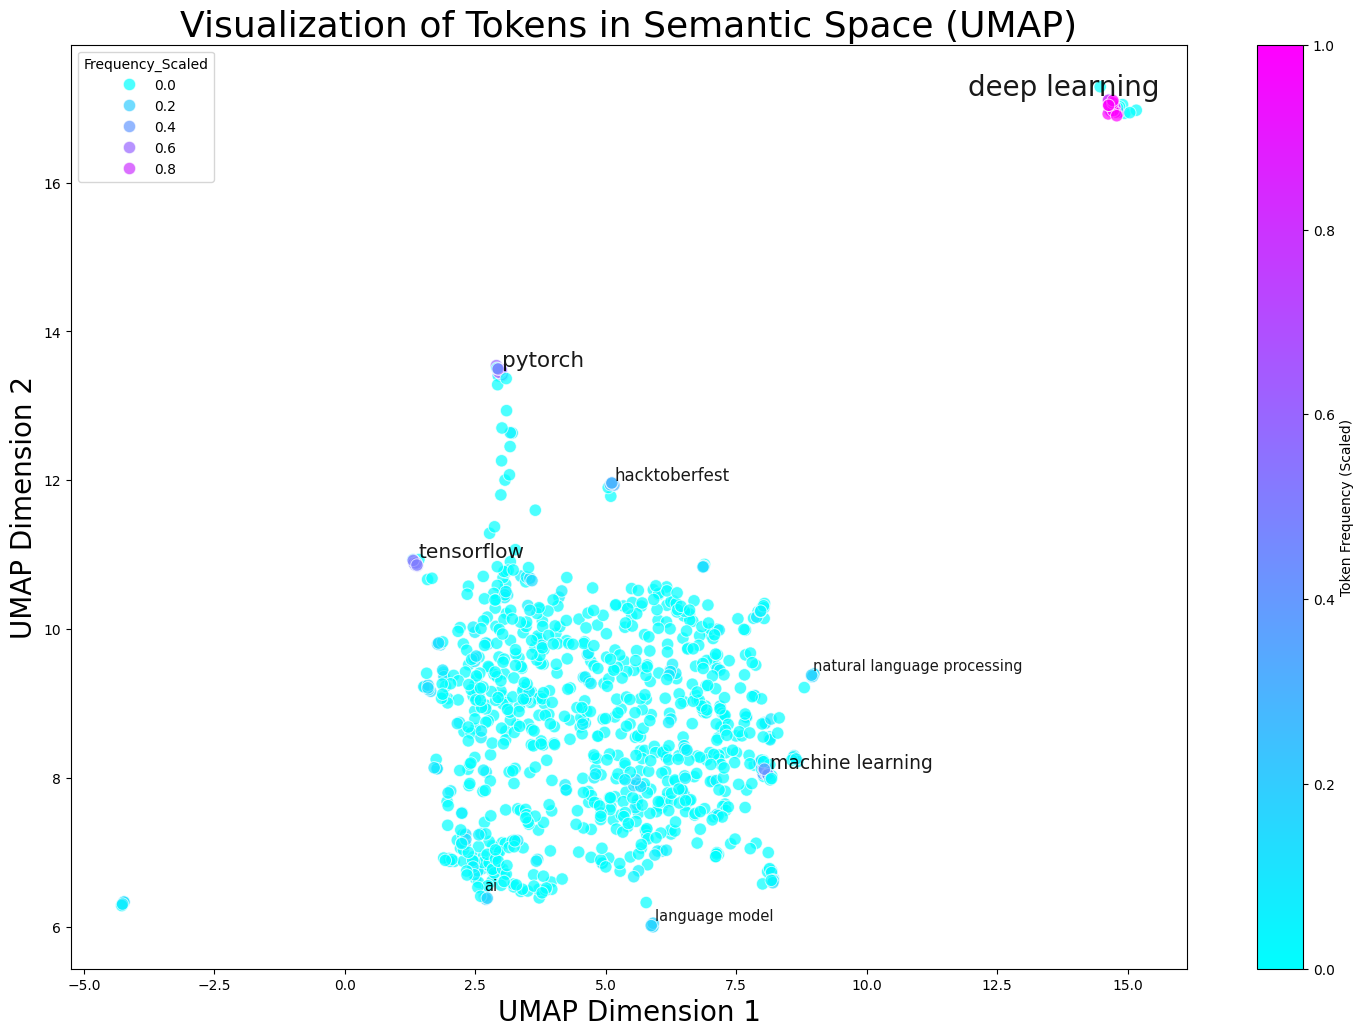

In [15]:

# ---- 1. Sample of sub vectors ----
sample_size = 1000
sample_indices = random.sample(range(len(all_vectors)), min(sample_size, len(all_vectors)))
sampled_vectors = [all_vectors[i] for i in sample_indices]
sampled_tokens = [all_tokens[i] for i in sample_indices]

# ---- 2. Dimensionality reduction using UMAP ----
umap_reducer = umap.UMAP(n_neighbors=30, n_components=2, metric='cosine', random_state=42, min_dist=0.1)
reduced_embeddings = umap_reducer.fit_transform(sampled_vectors)

# ---- 3. Data preparation for visualization ----
embedding_df = pd.DataFrame({
    'UMAP1': reduced_embeddings[:, 0],
    'UMAP2': reduced_embeddings[:, 1],
    'Token': sampled_tokens
})

# ---- 4. Key terms frequency ----
token_frequency = embedding_df['Token'].value_counts()
embedding_df['Frequency'] = embedding_df['Token'].map(token_frequency)

# ---- 5. Filter terms by their frequency ----
threshold_frequency = 5  # הצגת מונחים שמופיעים לפחות מספר פעמים זה
filtered_df = embedding_df[embedding_df['Frequency'] >= threshold_frequency]

# ---- 6. Normalize 0-1 ----
scaler = MinMaxScaler()
embedding_df['Frequency_Scaled'] = scaler.fit_transform(embedding_df[['Frequency']])


plt.figure(figsize=(18, 12))


ax = sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='Frequency_Scaled',
    palette='cool',
    data=embedding_df,
    s=80,
    alpha=0.7
)

# Color map
norm = plt.Normalize(embedding_df['Frequency_Scaled'].min(), embedding_df['Frequency_Scaled'].max())
sm = plt.cm.ScalarMappable(cmap='cool', norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Token Frequency (Scaled)', orientation='vertical')

# Add names
previous_tokens = set()
texts = []
for i, row in filtered_df.iterrows():
    x, y = row['UMAP1'], row['UMAP2']
    token = row['Token']

    if token not in previous_tokens:
        texts.append(plt.text(
            x,
            y,
            token,
            fontsize=min(20, 8 + row['Frequency'] / 2),
            alpha=0.9,
            weight='bold' if row['Frequency'] > 50 else 'normal'
        ))
        previous_tokens.add(token)

adjust_text(texts)

plt.title('Visualization of Tokens in Semantic Space (UMAP)', fontsize=26)
plt.xlabel('UMAP Dimension 1', fontsize=20)
plt.ylabel('UMAP Dimension 2', fontsize=20)
plt.show()


In [16]:
results_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/results_df.xlsx", index=False)

## Results Analysis with Precision, Recall, and F1 Score

### Step 1: Building a Smart Ground Truth - Simple Methods (Top K% and Percentiles)  

#### Purpose of This Step:  
To evaluate the relevance of each project using **CodeBERT** for creating an automatic ground truth metric.  

#### Basic Threshold Methods:  
1. **Top K%:**  
   - Selecting projects with the highest scores relative to each query.  

2. **Percentiles:**  
   - Using percentiles to define a dynamic threshold for each query.  

The goal is to determine whether these approaches are sufficient or if a more advanced method is needed (e.g., **Clustering / Contextual Relevance**).


In [17]:
# clean_df.to_excel("/content/drive/MyDrive/GitHubRepositoriesProject/clean_df.xlsx", index=False)

## Performance Analysis and Visualization


In [18]:
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(query_vector, all_vectors):
    """
    Calculate cosine similarity between the query vector and all_vectors.
    Returns a list of similarity scores.
    """
    similarities = cosine_similarity(np.array([query_vector]), all_vectors)
    return similarities.flatten()

def build_ground_truth(queries, embeddings, all_vectors, vector_to_repo, clean_df,
                       top_k_percent=0.1, percentile=90):
    """
    Build ground truth based on Top K% and Percentiles for multiple queries.

    Parameters:
    - queries: List of query strings.
    - embeddings: The embedding model used (CustomCodeBERTEmbeddings).
    - all_vectors: The FAISS embeddings for the projects.
    - vector_to_repo: Mapping from vector index to repo index.
    - clean_df: The DataFrame containing the project metadata.
    - top_k_percent: Percentage for Top K% filtering (e.g., 0.1 for Top 10%).
    - percentile: Percentile threshold for filtering (e.g., 90 for 90th percentile).

    Returns:
    - ground_truth_df: A DataFrame containing relevant results for each query.
    """
    results = []

    for query in queries:
        query_vector = embeddings.embed_query(query)
        similarities = calculate_similarity(query_vector, all_vectors)

        # Get Top K% results
        top_k_threshold = np.percentile(similarities, 100 - (top_k_percent * 100))
        top_k_indices = np.where(similarities >= top_k_threshold)[0]

        # Get Percentile-based results
        percentile_threshold = np.percentile(similarities, percentile)
        percentile_indices = np.where(similarities >= percentile_threshold)[0]

        # Combine results
        all_relevant_indices = np.unique(np.concatenate((top_k_indices, percentile_indices)))

        for idx in all_relevant_indices:
            repo_index = vector_to_repo[idx]
            repo_name = clean_df.iloc[repo_index]["Name"]
            repo_url = clean_df.iloc[repo_index]["URL"]
            repo_topics = clean_df.iloc[repo_index]["Topics"]
            score = similarities[idx]

            results.append({
                "query": query,
                "repo_name": repo_name,
                "repo_url": repo_url,
                "repo_topics": repo_topics,
                "score": score
            })

    # Create DataFrame for Ground Truth
    ground_truth_df = pd.DataFrame(results)
    return ground_truth_df

# ---- דוגמה להרצה ----
queries = ["deep learning", "neural networks", "python libraries", "computer vision", "natural language processing"]
ground_truth_df = build_ground_truth(
    queries=queries,
    embeddings=embeddings,
    all_vectors=all_vectors,
    vector_to_repo=vector_to_repo,
    clean_df=clean_df,
    top_k_percent=0.1,
    percentile=90
)

# הצגת מדגם מהתוצאות
ground_truth_df.head(10)


,query,repo_name,repo_url,repo_topics,score
0,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999771
1,deep learning,changedetection.io,https://github.com/dgtlmoon/changedetection.io,"back in stock, change alert, change detection,...",0.999455
2,deep learning,swarmlib,https://github.com/HaaLeo/swarmlib,"aco, ant colony optimization, artificial bee c...",0.999419
3,deep learning,swarmlib,https://github.com/HaaLeo/swarmlib,"aco, ant colony optimization, artificial bee c...",0.999449
4,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999483
5,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",1.000000
6,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999541
7,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999738
8,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999525
9,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999447


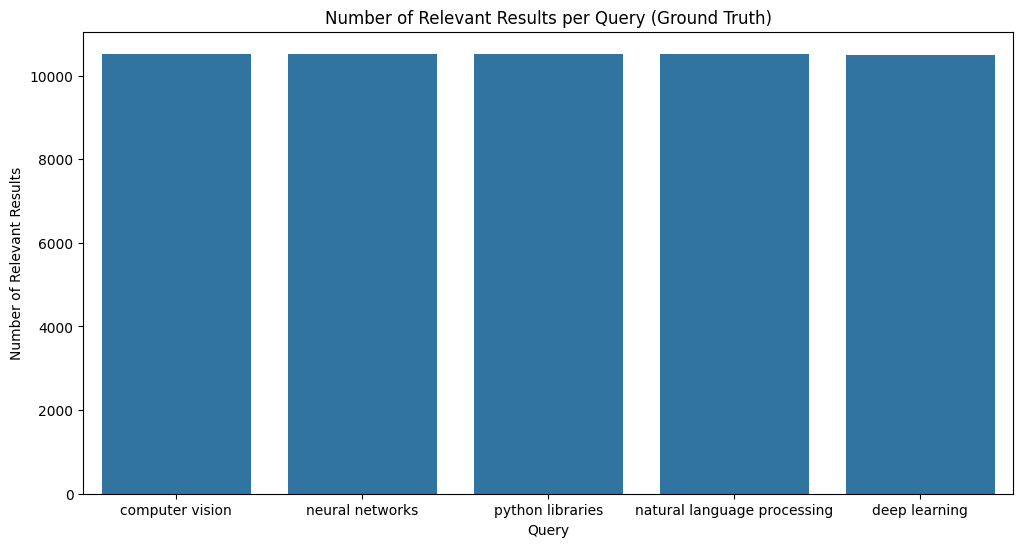

,query,repo_name,repo_url,repo_topics,score
0,deep learning,PyPOTS,https://github.com/WenjieDu/PyPOTS,"classification, clustering, data mining, forec...",0.999771
1,deep learning,changedetection.io,https://github.com/dgtlmoon/changedetection.io,"back in stock, change alert, change detection,...",0.999455
2,deep learning,swarmlib,https://github.com/HaaLeo/swarmlib,"aco, ant colony optimization, artificial bee c...",0.999419
3,deep learning,swarmlib,https://github.com/HaaLeo/swarmlib,"aco, ant colony optimization, artificial bee c...",0.999449
4,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999483
5,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",1.000000
6,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999541
7,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999738
8,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999525
9,deep learning,accel-brain-code,https://github.com/accel-brain/accel-brain-code,"auto encoder, automatic summarization, combina...",0.999447


In [19]:

def analyze_ground_truth(ground_truth_df):
    """
    Analyzing the distribution of the Ground Truth DataFrame to understand if it's reasonable.
    """
    # מספר התוצאות הרלוונטיות לכל שאילתה
    query_counts = ground_truth_df['query'].value_counts().reset_index()
    query_counts.columns = ['query', 'count']

    # הצגת התפלגות כמות התוצאות עבור כל שאילתה
    plt.figure(figsize=(12, 6))
    sns.barplot(x='query', y='count', data=query_counts)
    plt.title('Number of Relevant Results per Query (Ground Truth)')
    plt.xlabel('Query')
    plt.ylabel('Number of Relevant Results')
    plt.show()


analyze_ground_truth(ground_truth_df)
(ground_truth_df.head(10))

In [20]:
def compare_results_with_ground_truth(results_df, ground_truth_df):
    """
    Compare FAISS search results with Ground Truth and calculate Precision, Recall, and F1-Score.
    """
    precision_list, recall_list, f1_list = [], [], []

    for _, row in results_df.iterrows():
        query = row['query']
        found_projects = set(row['found_projects'])  # כל הפרויקטים שנמצאו ב-FAISS

        # שליפת הפרויקטים שנמצאו במדד האמת עבור אותה שאילתה
        relevant_projects = set(ground_truth_df[ground_truth_df['query'] == query]['repo_name'])

        if len(relevant_projects) == 0:
            precision_list.append(None)
            recall_list.append(None)
            f1_list.append(None)
            continue

        # חישוב מדדי Precision, Recall ו-F1
        true_positives = len(found_projects.intersection(relevant_projects))
        precision = true_positives / len(found_projects) if len(found_projects) > 0 else 0
        recall = true_positives / len(relevant_projects) if len(relevant_projects) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # הוספת המדדים לתוך ה-DataFrame של התוצאות
    results_df['precision'] = precision_list
    results_df['recall'] = recall_list
    results_df['f1'] = f1_list

    return results_df

# הרצת הפונקציה
results_df = compare_results_with_ground_truth(results_df, ground_truth_df)


    nlist  nprobe  precision    recall        f1
0     100      10   0.440000  0.000685  0.001367
1     100      20   0.411111  0.000627  0.001252
2     100      30   0.360000  0.000560  0.001118
3     100      50   0.460000  0.000709  0.001416
4     200      10   0.400000  0.000635  0.001268
5     200      20   0.413333  0.000626  0.001250
6     200      30   0.480000  0.000742  0.001481
7     200      50   0.282222  0.000432  0.000862
8     300      10   0.366667  0.000575  0.001147
9     300      20   0.348889  0.000532  0.001062
10    300      30   0.348889  0.000527  0.001052
11    300      50   0.308889  0.000457  0.000913
12    500      10   0.500000  0.000748  0.001493
13    500      20   0.400000  0.000623  0.001244
14    500      30   0.400000  0.000615  0.001227
15    500      50   0.351111  0.000535  0.001068


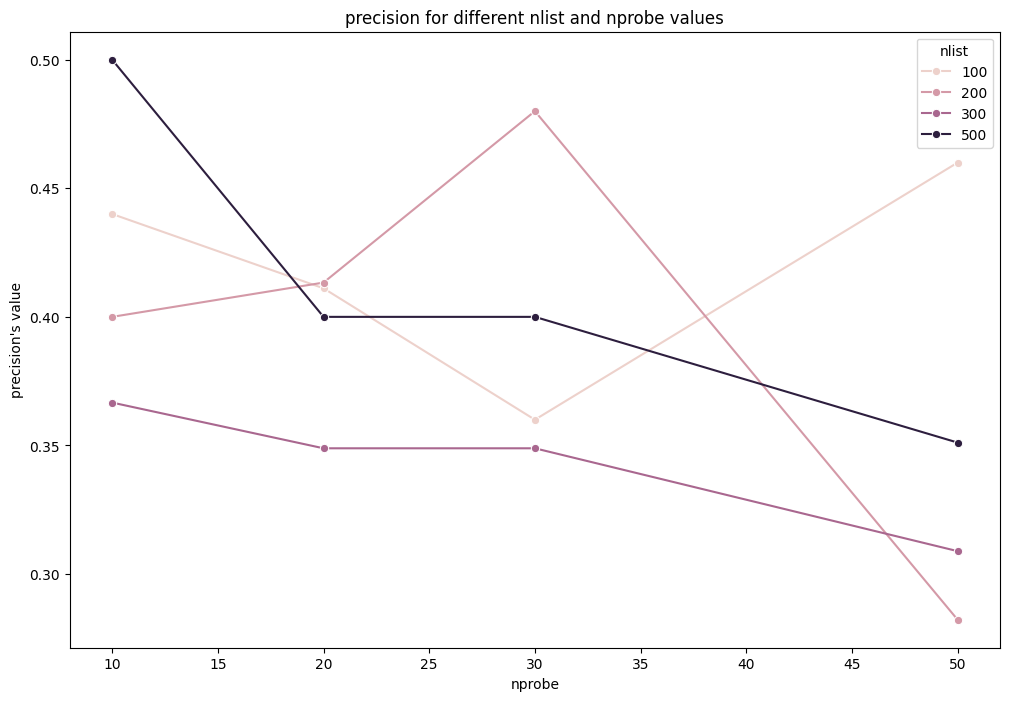

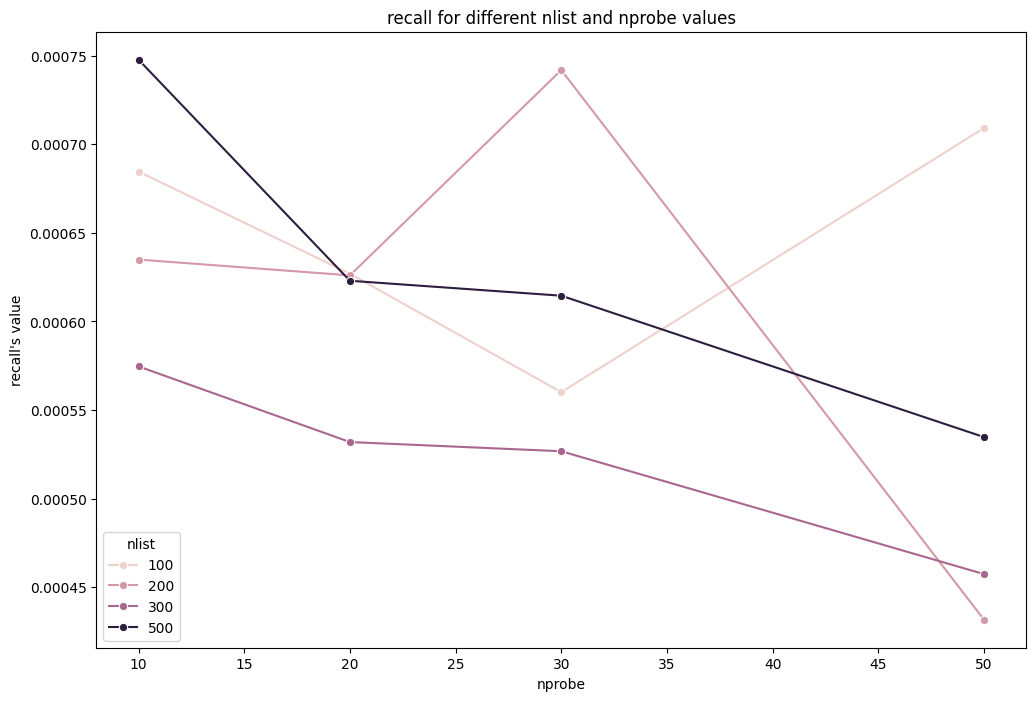

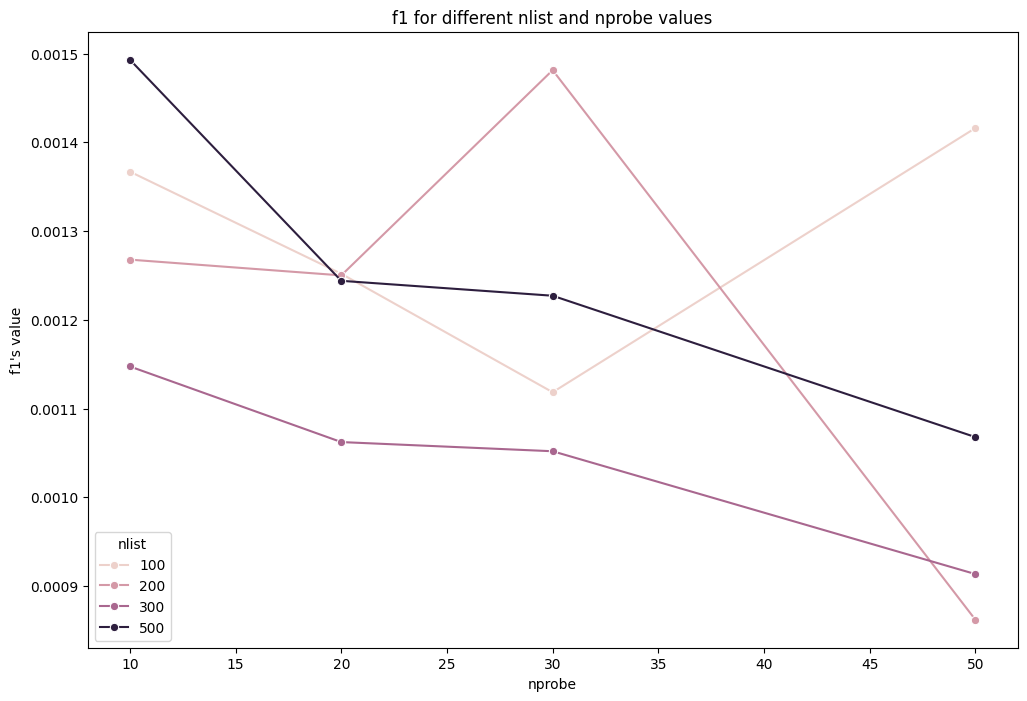

In [21]:
def lineplot_df(grouped,metric):

  plt.figure(figsize=(12, 8))
  sns.lineplot(data = grouped, x = 'nprobe', y=metric, hue='nlist', marker = 'o')

  plt.title(f"{metric} for different nlist and nprobe values")
  plt.xlabel("nprobe")
  plt.ylabel(f"{metric}'s value")
  plt.legend(title="nlist")
  plt.show()


def analyze_results(results_df):

  metrics = ['precision', 'recall', 'f1']
  grouped_results = results_df.groupby(['nlist', 'nprobe']).agg({
  'precision': 'mean',
  'recall': 'mean',
  'f1': 'mean'
  }).reset_index()


  print(grouped_results)

  [lineplot_df(grouped_results, metric) for metric in metrics]
analyze_results(results_df)

### The Effect of **nlist** and **nprobe** on Performance  

- **nlist:** Determines the number of clusters the data is divided into.  
  - Higher **nlist** can improve memory usage and accuracy but requires more time for training and searching.  

- **nprobe:** Determines how many of the clusters are searched during a query.  
  - Higher **nprobe** improves accuracy but also slows down the search process.  

The goal is to find a balance between **nlist** and **nprobe** that provides the best trade-off between speed and accuracy.

In [22]:
# grouped_results = analyze_results(results_df)

In [23]:
# grouped_results

In [24]:
# # בחר את השילוב עם ה-F1 הכי גבוה
# best_f1_score_row = results_df.loc[results_df['f1'].idxmax()]
# best_f1_score_row
